In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
cur_path = "/content/drive/MyDrive/BDB 2025/"
os.chdir(cur_path)
!pwd

Mounted at /content/drive
/content/drive/MyDrive/BDB 2025


In [ ]:
# ! pwd

/content/drive/MyDrive/BDB 2025


In [ ]:
# !ls

01-Preprocessing.ipynb	02-DataExploration.ipynb


In [ ]:
# from google.colab import files
# files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mattflaherty97","key":"0b4f4dab91364f0870e4db20e8769669"}'}

In [ ]:
# ! mkdir ~/.kaggle

# ! cp kaggle.json ~/.kaggle/

# ! chmod 600 ~/.kaggle/kaggle.json

# !kaggle competitions download -c nfl-big-data-bowl-2025

# ! mkdir ./data

# ! unzip nfl-big-data-bowl-2025.zip -d data/

In [2]:
!pip install pyspark

# The entry point to programming Spark with the DataFrame API.
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[4]").appName("DataFrame").getOrCreate()

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 500)

from pyspark.sql.functions import *
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.functions import sqrt

In [4]:
games = spark.read.option("header",'True').csv('./data/games.csv')
players = spark.read.option("header",'True').csv('./data/players.csv')
plays = spark.read.option("header",'True').csv('./data/plays.csv')
player_play = spark.read.option("header",'True').csv('./data/player_play.csv')
tracking = spark.read.option("header",'True').csv('./data/tracking_week*.csv')

In [ ]:
# track_games = tracking.join(games, on=['gameId'], how='left')
# make sure we have all the weeks of tracking data
# track_games.groupby('week').count().show()

+----+-------+
|week|  count|
+----+-------+
|   1|7104700|
|   2|6704339|
|   3|7129195|
|   4|6747556|
|   5|7103067|
|   6|6239486|
|   7|6023631|
|   8|6603714|
|   9|5671685|
+----+-------+



# Normalize

In [5]:
# normalize so every play moves in the same direction
tracking = tracking.join(plays.select('gameId','playId','possessionTeam','isDropback'), on=['gameId','playId'], how='left')
tracking = tracking.withColumn('isOnOffense', F.when(F.col('club') == F.col('possessionTeam'), 1).otherwise(0))
tracking = tracking.withColumn('ToLeft', F.when(F.col('playDirection') == 'left', 1).otherwise(0))
tracking = tracking.withColumn('X_std', F.when(F.col('ToLeft') == 1, 120-tracking.x).otherwise(tracking.x))
tracking = tracking.withColumn('Y_std', F.when(F.col('ToLeft') == 1, 160/3-tracking.y).otherwise(tracking.y))

In [ ]:
# use sample play to see how current data looks
# need 2 plays to compare where the direction is different
# after normalization, the teams should be moving in the same direction

# going right
sample_play1 = tracking.filter((tracking.gameId == 2022091200) & (tracking.playId == 64) & (tracking.frameId == 114))
sample_play1 = sample_play1.toPandas()

# going left
sample_play2 = tracking.filter((tracking.gameId == 2022091200) & (tracking.playId == 264) & (tracking.frameId == 111))
sample_play2 = sample_play2.toPandas()

In [ ]:
sample_play1['x'] = sample_play1['x'].astype('float')
sample_play1['y'] = sample_play1['y'].astype('float')
sample_play2['x'] = sample_play2['x'].astype('float')
sample_play2['y'] = sample_play2['y'].astype('float')
sample_play1['X_std'] = sample_play1['X_std'].astype('float')
sample_play1['Y_std'] = sample_play1['Y_std'].astype('float')
sample_play2['X_std'] = sample_play2['X_std'].astype('float')
sample_play2['Y_std'] = sample_play2['Y_std'].astype('float')

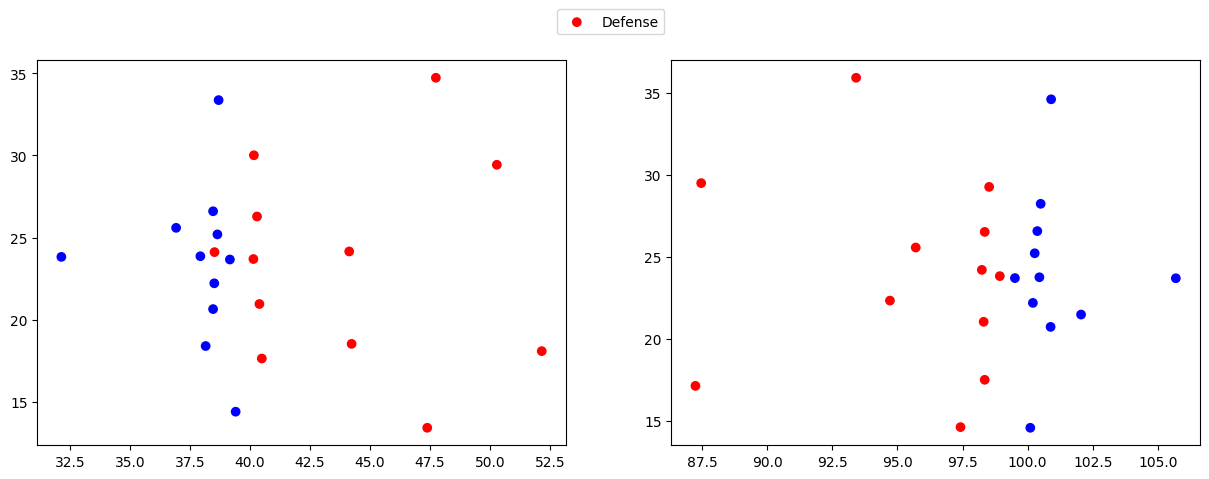

In [ ]:
# sanity check
# before normalization
# both teams are moving in different directions
fig, axs = plt.subplots(1,2,figsize=(15, 5))

directionCheck = sample_play1
colors = {1:'blue',0:'red','football':'brown'}
line1 = axs[0].scatter(directionCheck['x'], directionCheck['y'], c=directionCheck['isOnOffense'].map(colors))

directionCheck = sample_play2
colors = {True:'blue',False:'red','football':'brown'}
line2 = axs[1].scatter(directionCheck['x'], directionCheck['y'], c=directionCheck['isOnOffense'].map(colors))

axs[0].legend(('Defense','Offense'),loc="right",bbox_to_anchor=(1.2, 1.1))
# fig.legend([axs[0], axs[1]], labels=['Offense','Defense'],
#            loc="upper right")
plt.show()

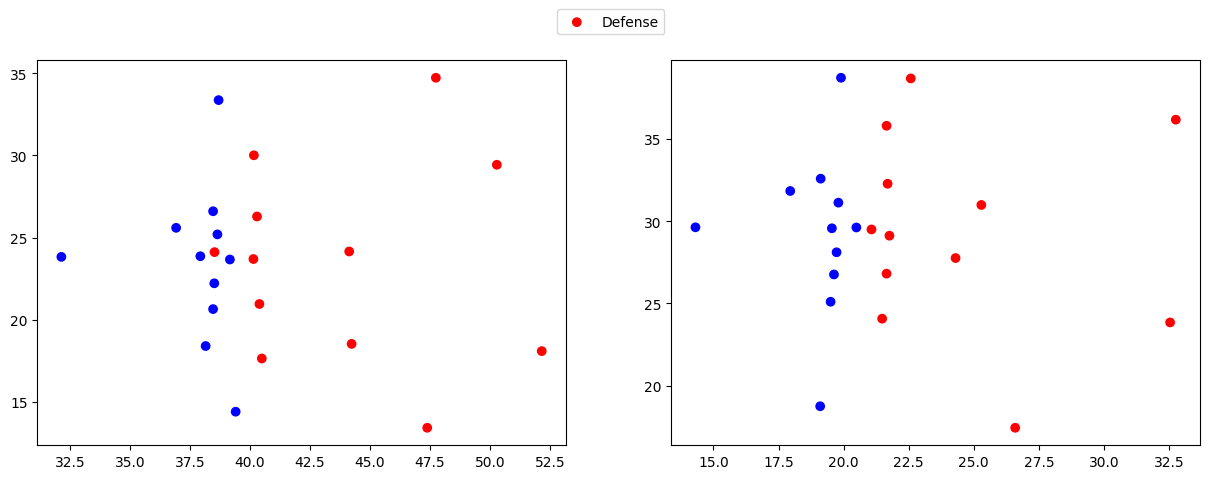

In [ ]:
# sanity check
# after normalization
# both teams are moving in the same direction
fig, axs = plt.subplots(1,2,figsize=(15, 5))

directionCheck = sample_play1
colors = {True:'blue',False:'red','football':'brown'}
axs[0].scatter(directionCheck['X_std'], directionCheck['Y_std'], c=directionCheck['isOnOffense'].map(colors))

directionCheck = sample_play2
colors = {True:'blue',False:'red','football':'brown'}
axs[1].scatter(directionCheck['X_std'], directionCheck['Y_std'], c=directionCheck['isOnOffense'].map(colors))

axs[0].legend(('Defense','Offense'),loc="right",bbox_to_anchor=(1.2, 1.1))
plt.show()

In [6]:
# standardize direction
tracking = tracking.withColumn('dir_std', when((col('ToLeft')==1) & (col('dir')<90), tracking.dir + 360).otherwise(tracking.dir))
tracking = tracking.withColumn('dir_std', when((col('ToLeft')==0) & (col('dir')>270), tracking.dir - 360).otherwise(tracking.dir_std))
tracking = tracking.withColumn('dir_std', when((col('ToLeft')==1), tracking.dir_std - 180).otherwise(tracking.dir_std))

In [7]:
# standardize orientation
tracking = tracking.withColumn('o_std', when((col('ToLeft')==1) & (col('o')<90), tracking.o + 360).otherwise(tracking.o))
tracking = tracking.withColumn('o_std', when((col('ToLeft')==0) & (col('o')>270), tracking.o - 360).otherwise(tracking.o_std))
tracking = tracking.withColumn('o_std', when((col('ToLeft')==1), tracking.o_std - 180).otherwise(tracking.o_std))

In [8]:
# filter out run plays, only need pass plays to predict route combos
tracking = tracking.filter(tracking.isDropback == 'TRUE')
# tracking.groupby('isDropback').count().show()

In [10]:
# filter out post snap plays
# post snap plays will make our model overfit
tracking = tracking.filter(tracking.frameType=='BEFORE_SNAP')

In [11]:
# partition tracking data back into weeks
tracking = tracking.join(games.select('gameId','week'), on=['gameId'], how='left')
# week1 = tracking.filter(tracking.week == 1)

In [ ]:
# week1.write.option("header",True).mode('overwrite').parquet("./data/tracking.parquet")

In [12]:
for i in range(1,10):
  weekn = tracking.filter(tracking.week == i)
  weekn.write.option("header",True).mode('overwrite').parquet(f"./data/tracking_week{i}.parquet")